## Food Classifiction

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Creating data loaders

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Model creation

Using transfer learning to leverage extensively trained models from tensorflow hub

In [5]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [6]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
import tf_keras
def create_model(model_url, num_classes):
    # Grabbing a pre-trained layer from tensorflow hub
    feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, input_shape=IMAGE_SHAPE+ (3,), name='feature_extraction_layer')
    
    model = tf_keras.Sequential()
    model.add(feature_extractor_layer)
    model.add(tf_keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax, name='output_layer'))
    
    return model 

Creating a ResNet model

In [10]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

2024-12-23 10:09:30.099818: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-23 10:09:30.099875: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-23 10:09:30.099897: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-23 10:09:30.099913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-23 10:09:30.099928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [12]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5


2024-12-23 10:09:39.454242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 21s 613ms/step - loss: 1.9000 - accuracy: 0.3667 - val_loss: 1.1959 - val_accuracy: 0.6204
Epoch 2/5
24/24 [==============================] - 12s 534ms/step - loss: 0.9045 - accuracy: 0.7227 - val_loss: 0.8532 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 12s 514ms/step - loss: 0.6220 - accuracy: 0.8387 - val_loss: 0.7391 - val_accuracy: 0.7616
Epoch 4/5
24/24 [==============================] - 12s 515ms/step - loss: 0.4754 - accuracy: 0.8760 - val_loss: 0.6917 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 12s 517ms/step - loss: 0.3783 - accuracy: 0.9093 - val_loss: 0.6752 - val_accuracy: 0.7688


Plotting loss curves for ResNet model

In [13]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
     

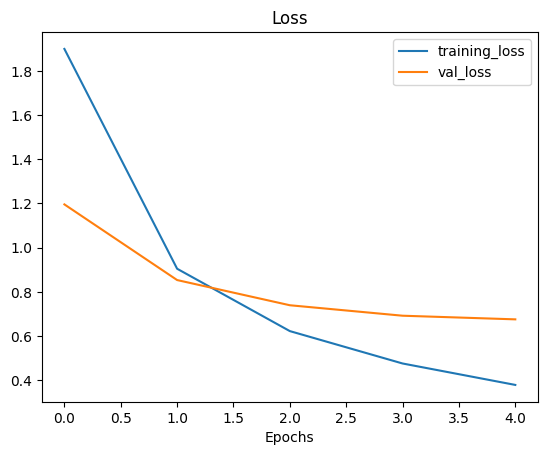

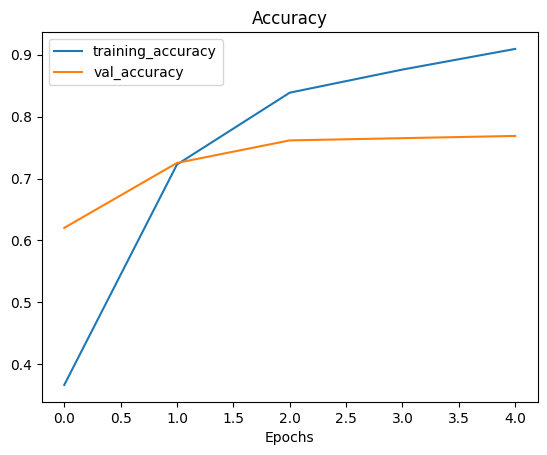

In [14]:
plot_loss_curves(resnet_history)

> Result Summary: The results are good but not greate since the 2 lines in both the graphs do not go together (Gradients are increasing/decreasing at the same rate). 

### Creating a model with EfficientNet80 feature extraction model

In [16]:
effnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)
effnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
effnet_history = effnet_model.fit(train_data_10_percent, 
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 16s 451ms/step - loss: 1.9266 - accuracy: 0.3960 - val_loss: 1.3789 - val_accuracy: 0.6988
Epoch 2/5
24/24 [==============================] - 9s 384ms/step - loss: 1.1030 - accuracy: 0.7653 - val_loss: 0.9189 - val_accuracy: 0.8048
Epoch 3/5
24/24 [==============================] - 9s 385ms/step - loss: 0.8143 - accuracy: 0.8120 - val_loss: 0.7167 - val_accuracy: 0.8360
Epoch 4/5
24/24 [==============================] - 9s 391ms/step - loss: 0.6134 - accuracy: 0.8787 - val_loss: 0.6165 - val_accuracy: 0.8616
Epoch 5/5
24/24 [==============================] - 9s 386ms/step - loss: 0.5176 - accuracy: 0.8933 - val_loss: 0.5756 - val_accuracy: 0.8596


Plotting loss curves for the model

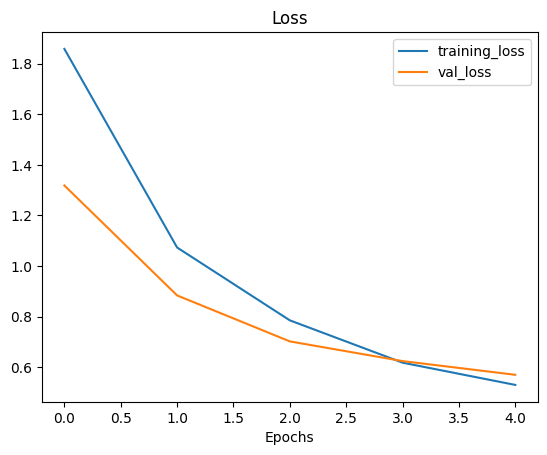

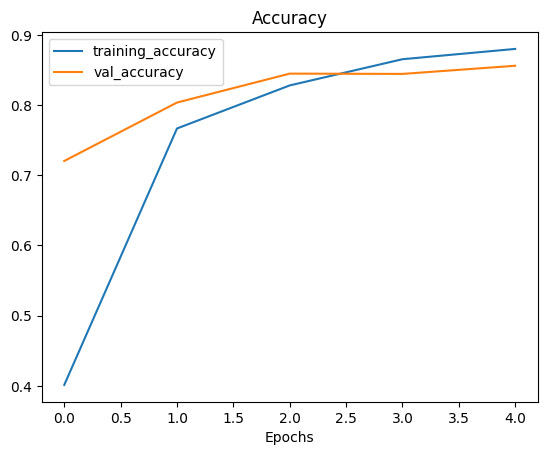

In [32]:
plot_loss_curves(effnet_history)

> Results Summary: The model has given better results! The lines in both graphs are almost meeting each other which is a sign of a well trained model.

### Making predictions with the models

In [17]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [18]:
class_names = ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger',
 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

In [19]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [20]:
def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)

    pred = model.predict(tf.expand_dims(img, axis=0))

    if len(pred[0]) > 1:
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 0s 97ms/step


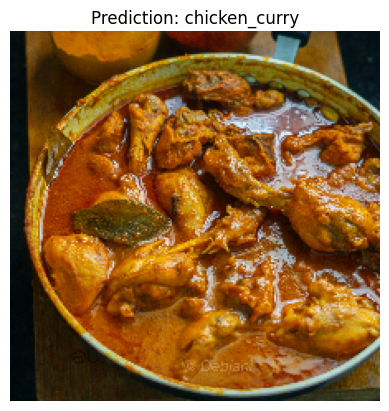

In [23]:
pred_and_plot(effnet_model, "test.jpg", class_names)

In [ ]:
effnet_model.save('food_pred.h5')